## Zadanie domowe: BBHE i DSIHE

W klasycznym wyrównywaniu histogramu HE  po wykonaniu operacji jasność obrazu ulega zmianie.
Dało się to zaobserwować podczas przeprowadzonych eksperymentów.
Jeśli nie to należy uruchomić skrypt z sekcji A i zwrócić na to uwagę.
Średnia jasność dąży do środkowego poziomu szarości.
Jest to wada i dlatego klasyczne HE ma ograniczone zastosowanie.

Powstało sporo metod, które eliminują to niekorzystne zjawisko.
Najprostsze z nich polegają na dekompozycji obrazu wejściowego na dwa podobrazy (wg. pewnego kryterium).
Następnie operacja HE wykonywana jest dla tych podobrazów.

Dwie znane z literatury metody to:
- Bi-Histogram Equalization
- DSIHE - Dualistic Sub-Image Histogram Equalization

W metodzie BBHE za kryterium podziału przyjmuje się średnią jasność w obrazie.
W DSIHE obraz dzieli się na dwa podobrazy o takiej samej liczbie pikseli (jaśniejszych i ciemniejszych).

W ramach zadania należy zaimplementować wybraną metodę: BBHE lub DSIHE (ew. obie).

1. Wczytaj obraz *jet.bmp* i wylicz jego histogram.
2. W kolejnym kroku należy wyznaczyć próg podziału obrazu na dwa podobrazy (*lm*).
3. Dla BBHE wyznacz średnią jasność obrazu. Dla DSIHE można wykorzystać histogram skumulowany.
Należy znaleźć poziom jasności który znajduje się "w połowie" histogramu skumulowanego.
W tym celu warto stworzyć tablicę, zawierającą moduł histogramu skumulowanego pomniejszonego o połowę liczby pikseli.
Następnie znaleźć minimum - `np.argmin`.
4. Dalej należy podzielić histogram oryginalnego obrazu na dwa histogramy *H1* i *H2*.
Dla każdego z nich wyliczyć histogram skumulowany ($C_1$ i $C_2$) i wykonać normalizację.
Normalizacja polega na podzieleniu każdego histogramu przez jego największy element.
5. Na podstawie histogramów skumulowanych należy stworzyć przekształcenie LUT.
Należy tak przeskalować $C_1$ i $C_2$, aby uzyskać jednorodne przekształcenie.
Tablicę $C_1$ wystarczy pomnożyć przez próg podziału.
Tablicę $C_2$ należy przeskalować do przedziału: $<lm+1; 255>$, gdzie $lm$ jest progiem podziału.<br>
$C_{1n} = (lm)*C1;$<br>
$C_{2n} = lm+1 + (255-lm-1)*C2;$<br>
Następnie dwie części tablicy przekodowań należy połączyć.
6. Ostatecznie należy wykonać operację LUT i wyświetlić wynik wyrównywania histogramu.
Porównaj wynik operacji BBHE lub DSIHE z klasycznym HE.

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/03_Histogram/'
fileName = 'jet.bmp'
if not os.path.exists(fileName) :
    r = requests.get(url + fileName, allow_redirects=True)
    open(fileName, 'wb').write(r.content)

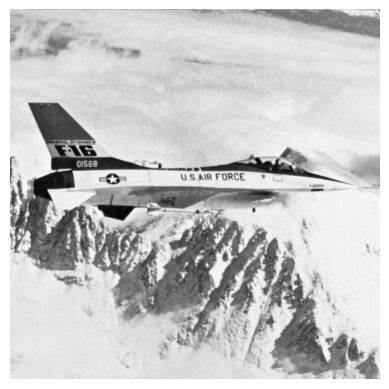

In [2]:
image = cv2.imread('jet.bmp', cv2.IMREAD_GRAYSCALE)
plt.imshow(image, 'gray')
plt.axis('off');

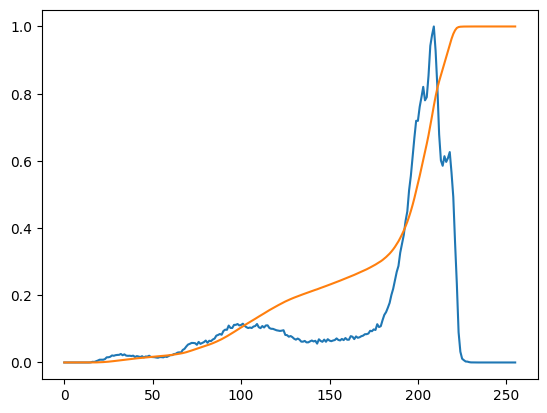

In [3]:
hist = cv2.calcHist([image], [0], None, [256], [0, 256])
cumulative = np.cumsum(hist)
plt.plot(hist / np.max(hist))
plt.plot(cumulative / np.max(cumulative));

In [4]:
bbhe_threshold = int(np.average(image))
dsihe_threshold = np.argmin(np.abs(cumulative - cumulative[-1] / 2))
print(bbhe_threshold, dsihe_threshold)

178 199


In [5]:
def transform(h, lm):
    h1 = h[:lm]
    h2 = h[lm:]
    c1, c2 = map(np.cumsum, (h1, h2))
    c1 /= c1[-1]
    c2 /= c2[-1]
    c1 = lm * c1
    c2 = (lm + 1) + (255 - lm - 1)*c2
    return np.hstack((c1, c2))

In [6]:
lut_bbhe = transform(hist, bbhe_threshold)

In [8]:
def draw_image_and_hist(img, lut):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 5)

    lutted = cv2.LUT(img, lut)
    ax[0].imshow(lutted, 'gray')
    ax[0].set_title("Jet")
    ax[0].axis('off')
    h = cv2.calcHist([lutted], [0], None, [256], [0, 256])
    ax[1].plot(h / np.max(h))
    ax[1].plot(np.cumsum(h) / np.sum(h))
    ax[1].set_title("Histogram and Cumulative")
    ax[2].plot(lut)
    ax[2].set_title("LUT function")

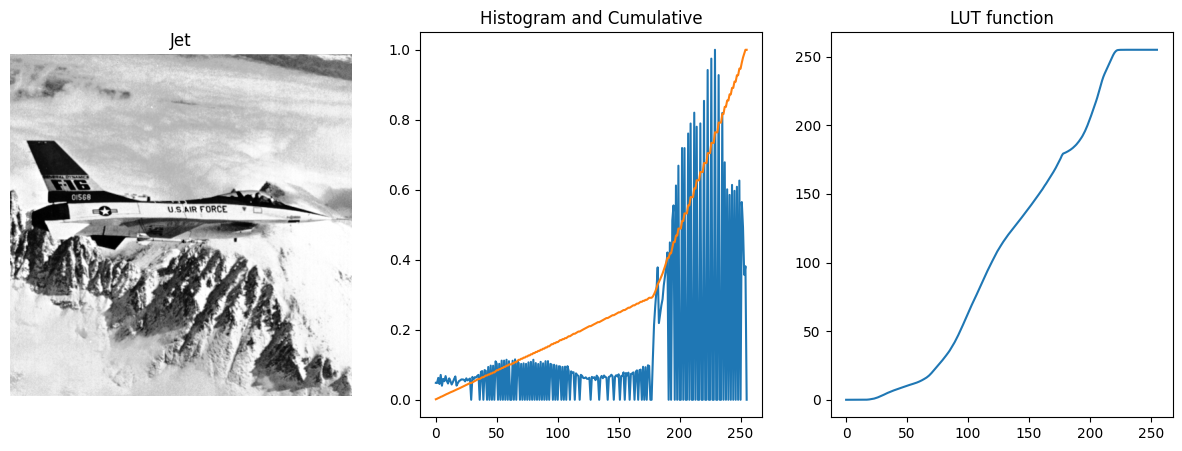

In [9]:
draw_image_and_hist(image, lut_bbhe)

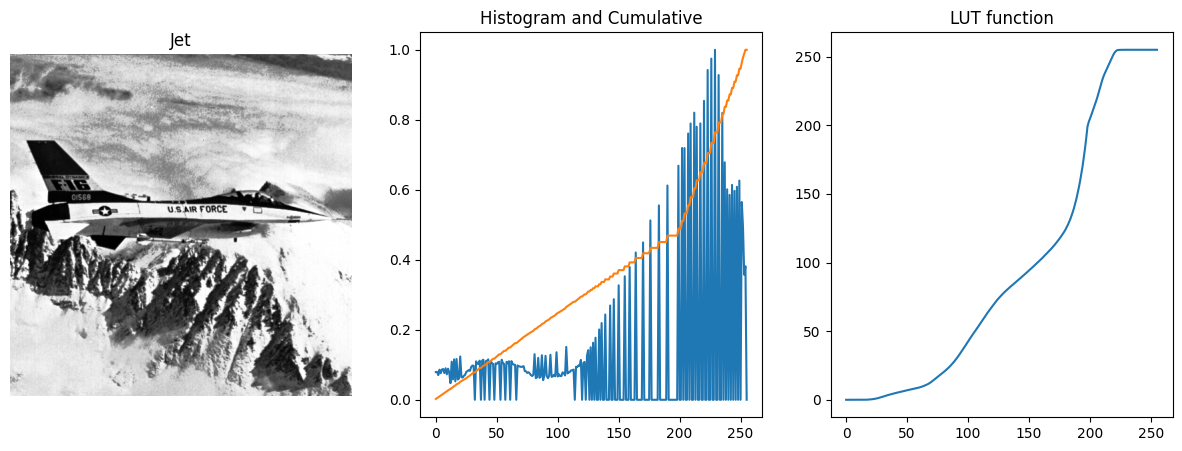

In [10]:
lut_dsihe = transform(hist, dsihe_threshold)
draw_image_and_hist(image, lut_dsihe)